In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import cv2
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mask_generator.transforms import AlbumentationsTrainTransform, KorniaInferTransform

In [2]:
# DATASET_CSV = "../Datasets/"
# df = pd.read_csv(DATASET_CSV)
# pairs_path = df[['image_path', 'mask_path']].values

IMAGE_PATH = "../Datasets/train/simu_v0/Images/image_0a0d47e7-edf5-4135-9e6e-0023a77aed58.png"
MASK_PATH = IMAGE_PATH.replace("Images", "Masks").replace("image", "mask")

Selected pair: ('../Datasets/train/simu_v0/Images/image_0a0d47e7-edf5-4135-9e6e-0023a77aed58.png', '../Datasets/train/simu_v0/Masks/mask_0a0d47e7-edf5-4135-9e6e-0023a77aed58.png')


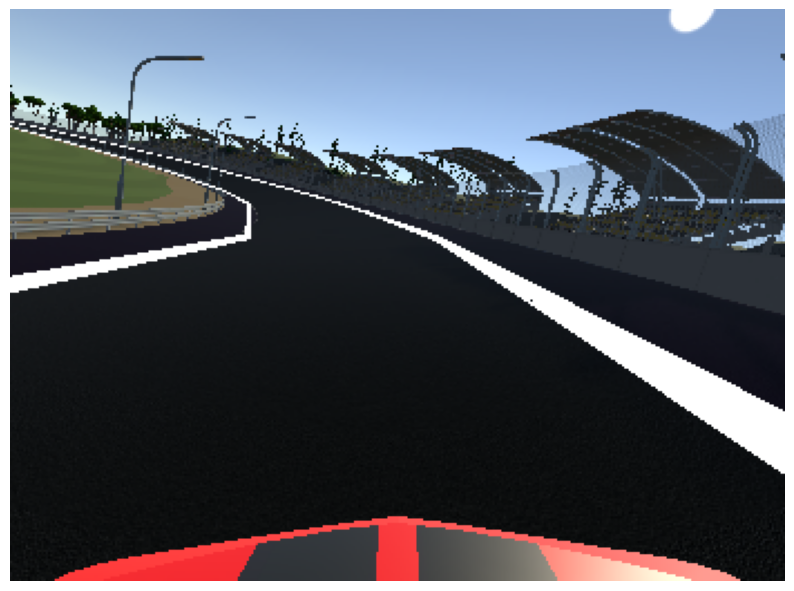

In [3]:
# pair = random.choice(pairs_path)
pair = (IMAGE_PATH, MASK_PATH)
print(f"Selected pair: {pair}")

original_image = cv2.imread(pair[0])
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

original_mask = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
original_mask = (original_mask >= 1).astype(np.uint8)

fig = plt.figure(figsize=(10, 10))
plt.imshow(original_image)
plt.axis('off')
plt.show()

In [4]:
IMAGE_SIZE = (256, 256 * 3) # (height, width)
PAD_DIVISOR = 32
AUGMENTATION_NAMES = ["blur", "noise", "dropout", "geometry", "color_invariance", "color_variation", "weather"]

train_transform = AlbumentationsTrainTransform(
    image_size=IMAGE_SIZE,
    pad_divisor=PAD_DIVISOR,
    augmentations=[],
)

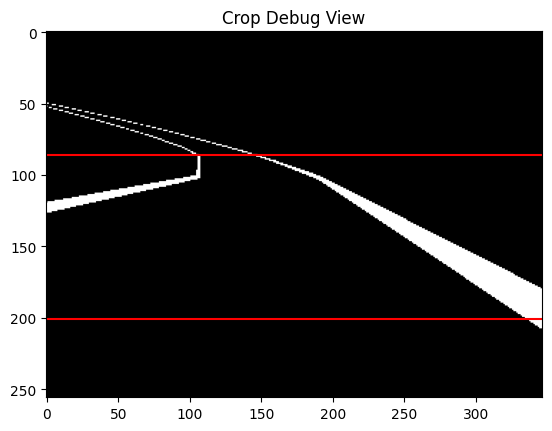

Image shape: torch.Size([3, 256, 768]), Mask shape: torch.Size([1, 256, 768])
Image max: 2.6399998664855957, min: -2.01515531539917
Image dtype: torch.float32
Image mean: -1.190747857093811, std: 1.1186619997024536


In [5]:
image, mask = train_transform(image=original_image, mask=original_mask)

print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")
print(f"Image max: {image.max()}, min: {image.min()}")
print(f"Image dtype: {image.dtype}")
print(f"Image mean: {image.mean()}, std: {image.std()}")

In [ ]:
train_image_np = train_transform.to_image(image)
train_mask_np = train_transform.to_mask(mask)

print(f"Train image max: {train_image_np.max()}, min: {train_image_np.min()}")
print(f"Train_image_np mean: {train_image_np.mean()}, std: {train_image_np.std()}")
print(f"Train image dtype: {train_image_np.dtype}")

Train image max: 255, min: 6
Train_image_np mean: 45.770261976453995, std: 63.611896255203995
Train image dtype: uint8


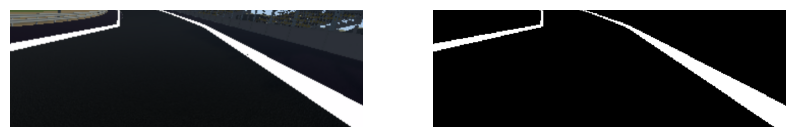

In [7]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(train_image_np)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(train_mask_np, cmap='gray')
plt.axis('off')
plt.show()

Crop coordinates: (86, 201)
Image shape: torch.Size([3, 256, 768]), Mask shape: torch.Size([1, 128, 352])
Image max: 2.640000104904175, min: -2.011354446411133
Image mean: -1.189185619354248, std: 1.1182743310928345
Image dtype: torch.float32
Min value: 6, Max value: 255
Mean value: 45.494666205512154, Std value: 63.682756494182456


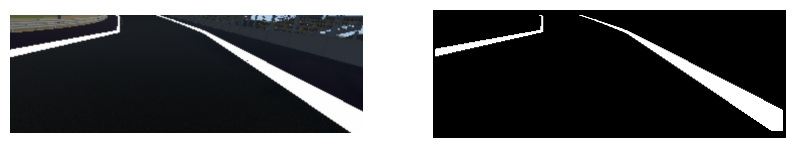

In [21]:
eval_transform = KorniaInferTransform(
    pad_divisor=PAD_DIVISOR,
    image_size=IMAGE_SIZE,
)
image_tensor, infer_mask = eval_transform(image=original_image, mask=original_mask)

print(f"Image shape: {image_tensor.shape}, Mask shape: {infer_mask.shape}")
print(f"Image max: {image_tensor.max()}, min: {image_tensor.min()}")
print(f"Image mean: {image_tensor.mean()}, std: {image_tensor.std()}")
print(f"Image dtype: {image_tensor.dtype}")

infer_image_np = eval_transform.to_image(image_tensor)
infer_mask_np = eval_transform.to_mask(infer_mask)

print(f"Min value: {infer_image_np.min()}, Max value: {infer_image_np.max()}")
print(f"Mean value: {infer_image_np.mean()}, Std value: {infer_image_np.std()}")

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(infer_image_np)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(infer_mask_np, cmap='gray')
plt.axis('off')
plt.show()

In [18]:
# Seuil d'acceptation en intensité (0 à 255)
threshold = 200  # Ajustable selon la précision souhaitée

# Calcul des différences absolues par canal
diff = np.abs(train_image_np - infer_image_np)

# Détecte si un des canaux dépasse le seuil
diff_mask = np.any(diff > threshold, axis=-1)

max_diff = np.max(diff)
print(f"Max difference: {max_diff}")

Max difference: 255


In [19]:
total_diff_pixels = np.sum(diff_mask)
total_pixels = diff_mask.size
percentage_diff = (total_diff_pixels / total_pixels) * 100

print(f"Pixels dépassant le seuil de {threshold}: {total_diff_pixels} / {total_pixels} ({percentage_diff:.4f}%)")

Pixels dépassant le seuil de 200: 2645 / 196608 (1.3453%)


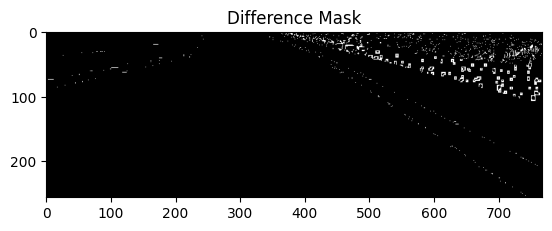

In [20]:
plt.imshow(diff_mask, cmap='gray')
plt.title("Difference Mask")
plt.show()